In [1]:
!pip install wandb
!pip install yfinance

In [2]:
pip install --upgrade ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6beca9ef535b5e0f84b83ec9f771d609a05bcf2562681b96190f499475857b75
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = DEBUG, 1 = INFO, 2 = WARNING, 3 = ERROR

In [4]:
# Bloc 1 : Import des librairies et configuration
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import datetime
import yfinance as yf
import tensorflow as tf
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pickle
import ta

# Configuration initiale de WandB
print("Initializing WandB...")
wandb.login()
wandb.ensure_configured()



Initializing WandB...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# Bloc 2 : Initialisation de WandB
def init_wandb_tracking(stock_symbol='BTC-USD'):
    try:
        # Définition des features de base
        base_features = ['Open', 'High', 'Low', 'Close', 'Volume']

        # Configuration des indicateurs techniques
        technical_config = {
            "moving_averages": {
                "enabled": True,
                "periods": [5, 10, 20],
                "features": ['MA_5', 'MA_10', 'MA_20', 'MA_5_pct', 'MA_10_pct', 'MA_20_pct']
            },
            "ema": {
                "enabled": True,
                "periods": [5, 10, 20],
                "features": ['EMA_5', 'EMA_10', 'EMA_20']
            },
            "rsi": {
                "enabled": True,
                "period": 21,
                "features": ['RSI']
            },
            "bollinger_bands": {
                "enabled": True,
                "period": 20,
                "features": ['BB_upper', 'BB_lower', 'BB_width']
            },
            "macd": {
                "enabled": False,
                "params": {"fast": 12, "slow": 26, "signal": 9},
                "features": ['MACD', 'MACD_signal', 'MACD_hist']
            },
            "stochastic": {
                "enabled": True,
                "period": 14,
                "features": ['Stoch_K', 'Stoch_D']
            },
            "momentum": {
                "enabled": True,
                "period": 10,
                "features": ['Momentum', 'ROC']
            },
            "volume": {
                "enabled": True,
                "ma_period": 20,
                "features": ['Volume_MA', 'Volume_ROC', 'OBV']
            },
            "atr": {
                "enabled": True,
                "period": 14,
                "features": ['ATR_14']
            },
            "adx": {
                "enabled": True,
                "period": 14,
                "features": ['ADX_14']
            },
            "ichimoku": {
                "enabled": True,
                "features": ['Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Conversion', 'Ichimoku_Base']
            },
            "vwap": {
                "enabled": True,
                "features": ['VWAP']
            },
            "cmf": {  # Nouvel indicateur
                "enabled": True,
                "period": 20,
                "features": ['CMF_20']
            },
            "cci": {  # Nouvel indicateur
                "enabled": True,
                "period": 20,
                "features": ['CCI_20']
            },
            "trix": {  # Nouvel indicateur
                "enabled": True,
                "period": 15,
                "features": ['Trix_15']
            },
            "williams_r": {  # Nouvel indicateur
                "enabled": True,
                "period": 14,
                "features": ['WilliamsR_14']
            }
        }

        # Construction des features actives
        active_features = base_features.copy()
        for indicator, cfg in technical_config.items():
            if cfg["enabled"]:
                active_features.extend(cfg["features"])

        # Initialisation de WandB
        run = wandb.init(
            project="crypto_lstm",
            name=f"lstm_{stock_symbol}_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}",
            tags=[stock_symbol, "short_term", "Deep Learning", "LSTM", "Optimized"],
            settings=wandb.Settings(init_timeout=120),
            mode="disabled",  # Définir sur "online" pour permettre les sweeps
            config={
                "data": {
                    "window_size": 90,
                    "future_prediction_days": 30,
                    "train_test_split": 0.7,
                    "features": active_features,
                    "stock_symbol": stock_symbol,
                    "seed": 42,
                    "scaling_min": 0,
                    "scaling_max": 1,
                    "dataset_info": {},
                },
                "technical_features": technical_config,
                "training": {
                    "optimizer": "sgd",
                    "batch_size": 128,
                    "epochs": 100,
                    "learning_rate": 0.00995,
                    "dropout_rate": 0.23976834504739084,
                    "early_stopping": True,
                    "early_stopping_patience": 15,
                    "validation_split": 0.3,
                    "num_layers": 3,
                    "units_per_layer": [512, 256],
                    "recurrent_dropout": 0.3317792678391172,
                    "momentum": 0.7773944766306407,
                    "intermediate_dense_units": 128,
                    "optimizer_params": {
                        "rmsprop": {
                            "rho": 0.9,
                            "epsilon": 1e-07
                        },
                        "adam": {
                            "epsilon": 1e-07
                        }
                    },
                },
                "model": {
                    "architecture": "lstm_double",
                    "batch_normalization": False,
                    "activation": "tanh",
                    "input_shape": None,  # Sera mis à jour pendant l'exécution
                    "output_shape": 1,    # Pour la prédiction univariée
                    "save_format": "keras"
                },
                "metrics": {
                    "loss": "huber",
                    "val_loss": "mse",
                    "mae": True,
                    "rmse": True,
                    "r2_score": True,
                    "mape": True,
                    "mase": True,
                    "directional_accuracy": True,
                    "training_history": {  # Ajouté pour suivre l'historique
                        "loss": None,
                        "val_loss": None,
                        "final_epoch": None,
                        "learning_rate": None
                    }
                },
                "callbacks": {
                    "early_stopping": {
                        "monitor": "val_loss",
                        "patience": 20,
                        "restore_best_weights": True
                    },
                    "reduce_lr_on_plateau": {
                        "monitor": "val_loss",
                        "factor": 0.46687704937797136,
                        "patience": 5,
                        "min_lr": 0.00001
                    },
                    "model_checkpoint": {
                        "save_best_only": True,
                        "monitor": "val_loss",
                        "filepath": None  # Sera défini avec wandb.run.id
                    }
                },
                "artifacts": {  # Nouveau: pour suivre les artefacts générés
                    "model_path": None,
                    "scaler_path": "scaler.pkl",
                    "best_model_path": "best_model.keras"
                }
            }
        )
        print(f"WandB run initialized with ID: {run.id}")
        return run
    except Exception as e:
        print(f"Error initializing WandB: {str(e)}")
        return None



In [6]:
# Bloc 3 : Import et prétraitement des données
def import_and_preprocess_data():
    try:
        print("\n" + "="*50)
        print("DÉBUT DE L'IMPORTATION ET PRÉTRAITEMENT DES DONNÉES")
        print("="*50)

        # Vérification que WandB est initialisé
        if wandb.run is None:
            raise Exception("WandB n'est pas initialisé")

        # Initialisation du seed
        print("\n[1] Configuration du seed...")
        np.random.seed(wandb.config.data['seed'])
        print(f"✓ Seed configuré à: {wandb.config.data['seed']}")

        # Récupération des données
        print("\n[2] Téléchargement des données depuis Yahoo Finance...")
        print(f"Symbole recherché: {wandb.config.data['stock_symbol']}")
        data = yf.download(wandb.config.data['stock_symbol'])

        # Vérification des données
        if data.empty:
            raise Exception("Aucune donnée n'a été récupérée")

        print("\n[3] Analyse des données:")
        print(f"✓ Nombre d'enregistrements: {len(data):,}")
        print(f"✓ Période: {data.index.min().strftime('%Y-%m-%d')} au {data.index.max().strftime('%Y-%m-%d')}")

        # Gestion du MultiIndex
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [f"{col[0]}" for col in data.columns]

        # Vérification des valeurs manquantes
        missing_values = data.isnull().sum()
        if missing_values.any():
            print("\n[4] Traitement des valeurs manquantes")
            data.fillna(method='ffill', inplace=True)
            print("✓ Valeurs manquantes comblées")

        # Log WandB minimal
        wandb.log({
            "data_import": {
                "dataset_size": len(data),
                "missing_values": bool(missing_values.any()),
                "date_range": {
                    "start": data.index.min().strftime('%Y-%m-%d'),
                    "end": data.index.max().strftime('%Y-%m-%d')
                }
            }
        })

        print("\n" + "="*50)
        print("FIN DE L'IMPORTATION ET PRÉTRAITEMENT DES DONNÉES")
        print("="*50)

        return data

    except Exception as e:
        print(f"\n❌ ERREUR: {str(e)}")
        wandb.log({"data_import_error": str(e)})
        raise

# Séquence d'exécution
try:
    # 1. Initialisation de WandB
    run = init_wandb_tracking()
    if run is None:
        raise Exception("Échec de l'initialisation de WandB")

    # 2. Import et prétraitement des données
    data = import_and_preprocess_data()

    print("\nInitialisation complète!")

except Exception as e:
    print(f"\n❌ ERREUR FATALE: {str(e)}")
    if wandb.run is not None:
        wandb.finish()

WandB run initialized with ID: et6e892e

DÉBUT DE L'IMPORTATION ET PRÉTRAITEMENT DES DONNÉES

[1] Configuration du seed...
✓ Seed configuré à: 42

[2] Téléchargement des données depuis Yahoo Finance...
Symbole recherché: BTC-USD


[*********************100%***********************]  1 of 1 completed


[3] Analyse des données:
✓ Nombre d'enregistrements: 3,768
✓ Période: 2014-09-17 au 2025-01-09

FIN DE L'IMPORTATION ET PRÉTRAITEMENT DES DONNÉES

Initialisation complète!


In [7]:
# Bloc 4 : Ajout des indicateurs techniques
def add_technical_indicators(df, config):
    print("\n" + "="*50)
    print("DÉBUT DE L'AJOUT DES INDICATEURS TECHNIQUES")
    print("="*50)

    original_length = len(df)
    initial_features = set(df.columns)
    tech_features = config['technical_features']  # Accès correct aux clés

    print(f"\nDonnées initiales:")
    print(f"✓ Nombre d'enregistrements: {original_length:,}")
    print(f"✓ Features initiales: {', '.join(initial_features)}")

    # Compteur pour les indicateurs ajoutés
    indicators_added = []

    # 1. Moyennes Mobiles (Moving Averages)
    if tech_features['moving_averages']['enabled']:
        print("\n[1] Ajout des Moyennes Mobiles")
        for period in tech_features['moving_averages']['periods']:
            df[f'MA_{period}'] = df['Close'].rolling(window=period).mean()
            df[f'MA_{period}_pct'] = df['Close'].pct_change(periods=period)
            indicators_added.extend([f'MA_{period}', f'MA_{period}_pct'])
        print(f"✓ Périodes utilisées: {tech_features['moving_averages']['periods']}")

    # 2. Moyennes Mobiles Exponentielles (EMA)
    if tech_features.get('ema', {}).get('enabled', False):
        print("\n[2] Ajout des Moyennes Mobiles Exponentielles (EMA)")
        for period in tech_features['ema']['periods']:
            df[f'EMA_{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
            indicators_added.append(f'EMA_{period}')
        print(f"✓ Périodes EMA: {tech_features['ema']['periods']}")

    # 3. RSI (Relative Strength Index)
    if tech_features['rsi']['enabled']:
        print("\n[3] Calcul du RSI")
        period = tech_features['rsi']['period']
        rsi = ta.momentum.RSIIndicator(close=df['Close'], window=period)
        df['RSI'] = rsi.rsi()
        indicators_added.append('RSI')
        print(f"✓ Période RSI: {period}")

    # 4. Bandes de Bollinger (Bollinger Bands)
    if tech_features['bollinger_bands']['enabled']:
        print("\n[4] Calcul des Bandes de Bollinger")
        period = tech_features['bollinger_bands']['period']
        bollinger = ta.volatility.BollingerBands(close=df['Close'], window=period, window_dev=2)
        df['BB_upper'] = bollinger.bollinger_hband()
        df['BB_lower'] = bollinger.bollinger_lband()
        df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['Close']
        indicators_added.extend(['BB_upper', 'BB_lower', 'BB_width'])
        print(f"✓ Période Bollinger: {period}")

    # 5. MACD (Moving Average Convergence Divergence)
    if tech_features['macd']['enabled']:
        print("\n[5] Calcul du MACD")
        fast = tech_features['macd']['params']['fast']
        slow = tech_features['macd']['params']['slow']
        signal = tech_features['macd']['params']['signal']
        macd = ta.trend.MACD(close=df['Close'], window_slow=slow, window_fast=fast, window_sign=signal)
        df['MACD'] = macd.macd()
        df['MACD_signal'] = macd.macd_signal()
        df['MACD_hist'] = macd.macd_diff()
        indicators_added.extend(['MACD', 'MACD_signal', 'MACD_hist'])
        print(f"✓ Paramètres MACD: fast={fast}, slow={slow}, signal={signal}")

    # 6. Oscillateur Stochastique (Stochastic Oscillator)
    if tech_features['stochastic']['enabled']:
        print("\n[6] Calcul du Stochastique")
        period = tech_features['stochastic']['period']
        stochastic = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=period, smooth_window=3)
        df['Stoch_K'] = stochastic.stoch()
        df['Stoch_D'] = stochastic.stoch_signal()
        indicators_added.extend(['Stoch_K', 'Stoch_D'])
        print(f"✓ Période Stochastique: {period}")

    # 7. Momentum et ROC (Rate of Change)
    if tech_features['momentum']['enabled']:
        print("\n[7] Calcul du Momentum et ROC")
        period = tech_features['momentum']['period']
        try:
            # Utiliser le paramètre correct 'lbp'
            williams_r = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=period)
            df['WilliamsR_14'] = williams_r.williams_r()
            indicators_added.append('WilliamsR_14')
            print(f"✓ Période Williams %R: {period}")
        except TypeError as te:
            print(f"❌ Erreur lors du calcul de Williams %R: {str(te)}")
            indicators_added.append('WilliamsR_Error')
            # Optionnel : Vous pouvez décider de lever l'exception ou de continuer
            raise

        try:
            # Tente d'utiliser MomentumIndicator
            df['Momentum'] = ta.momentum.MomentumIndicator(close=df['Close'], window=period).momentum()
            indicators_added.append('Momentum')
            print(f"✓ Période Momentum: {period}")
        except AttributeError:
            print("⚠ MomentumIndicator n'est pas disponible. Utilisation de ROCIndicator comme alternative.")
            # Utilisation de ROCIndicator pour Momentum
            try:
                df['Momentum'] = ta.momentum.ROCIndicator(close=df['Close'], window=period).roc()
                indicators_added.append('Momentum (ROC)')
                print(f"✓ Période ROC utilisée pour Momentum: {period}")
            except AttributeError:
                print("⚠ ROCIndicator n'est pas disponible. Calcul manuel du Momentum.")
                df['Momentum'] = df['Close'] - df['Close'].shift(period)
                indicators_added.append('Momentum (manual)')
                print(f"✓ Période Momentum (manuel): {period}")

        # Calcul du ROC
        try:
            df['ROC'] = ta.momentum.ROCIndicator(close=df['Close'], window=period).roc()
            indicators_added.append('ROC')
            print(f"✓ Période ROC: {period}")
        except AttributeError:
            print("⚠ ROCIndicator n'est pas disponible. Calcul manuel du ROC.")
            df['ROC'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period)) * 100
            indicators_added.append('ROC (manual)')
            print(f"✓ Période ROC (manuel): {period}")

    # 8. Indicateurs de Volume
    if tech_features['volume']['enabled']:
        print("\n[8] Calcul des Indicateurs de Volume")
        ma_period = tech_features['volume']['ma_period']
        df['Volume_MA'] = df['Volume'].rolling(window=ma_period).mean()
        df['Volume_ROC'] = df['Volume'].pct_change()
        obv = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'])
        df['OBV'] = obv.on_balance_volume()
        indicators_added.extend(['Volume_MA', 'Volume_ROC', 'OBV'])
        print(f"✓ Période Volume MA: {ma_period}")

    # 9. Average True Range (ATR)
    if tech_features.get('atr', {}).get('enabled', False):
        print("\n[9] Calcul de l'Average True Range (ATR)")
        period = tech_features['atr']['period']
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=period)
        df['ATR_14'] = atr.average_true_range()
        indicators_added.append('ATR_14')
        print(f"✓ Période ATR: {period}")

    # 10. Average Directional Index (ADX)
    if tech_features.get('adx', {}).get('enabled', False):
        print("\n[10] Calcul de l'Average Directional Index (ADX)")
        period = tech_features['adx']['period']
        adx = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=period)
        df['ADX_14'] = adx.adx()
        indicators_added.append('ADX_14')
        print(f"✓ Période ADX: {period}")

    # 11. Ichimoku Cloud
    if tech_features.get('ichimoku', {}).get('enabled', False):
        print("\n[11] Calcul de l'Ichimoku Cloud")
        ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
        df['Ichimoku_Conversion'] = ichimoku.ichimoku_conversion_line()
        df['Ichimoku_Base'] = ichimoku.ichimoku_base_line()
        df['Ichimoku_A'] = ichimoku.ichimoku_a()
        df['Ichimoku_B'] = ichimoku.ichimoku_b()
        indicators_added.extend(['Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Conversion', 'Ichimoku_Base'])
        print("✓ Ichimoku Cloud calculé avec succès")

    # 12. Volume Weighted Average Price (VWAP)
    if tech_features.get('vwap', {}).get('enabled', False):
        print("\n[12] Calcul du Volume Weighted Average Price (VWAP)")
        vwap = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14)
        df['VWAP'] = vwap.volume_weighted_average_price()
        indicators_added.append('VWAP')
        print("✓ VWAP calculé avec succès")

    # 13. Chaikin Money Flow (CMF)
    if tech_features.get('cmf', {}).get('enabled', False):
        print("\n[13] Calcul du Chaikin Money Flow (CMF)")
        period = tech_features['cmf']['period']
        cmf = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=period)
        df['CMF_20'] = cmf.chaikin_money_flow()
        indicators_added.append('CMF_20')
        print(f"✓ Période CMF: {period}")

    # 14. Commodity Channel Index (CCI)
    if tech_features.get('cci', {}).get('enabled', False):
        print("\n[14] Calcul du Commodity Channel Index (CCI)")
        period = tech_features['cci']['period']
        cci = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=period)
        df['CCI_20'] = cci.cci()
        indicators_added.append('CCI_20')
        print(f"✓ Période CCI: {period}")

    # 15. Trix (Triple Exponential Average)
    if tech_features.get('trix', {}).get('enabled', False):
        print("\n[15] Calcul du Trix (Triple Exponential Average)")
        period = tech_features['trix']['period']
        trix = ta.trend.TRIXIndicator(close=df['Close'], window=period)
        df['Trix_15'] = trix.trix()
        indicators_added.append('Trix_15')
        print(f"✓ Période Trix: {period}")

    # 16. Williams %R
    if tech_features.get('williams_r', {}).get('enabled', False):
        print("\n[16] Calcul du Williams %R")
        period = tech_features['williams_r']['period']
        try:
            # Utiliser le paramètre correct 'lbp'
            williams_r = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=period)
            df['WilliamsR_14'] = williams_r.williams_r()
            indicators_added.append('WilliamsR_14')
            print(f"✓ Période Williams %R: {period}")
        except TypeError as te:
            print(f"❌ Erreur lors du calcul de Williams %R: {str(te)}")
            indicators_added.append('WilliamsR_Error')
            # Optionnel : Vous pouvez décider de lever l'exception ou de continuer
            raise

    # Nettoyage final
    print("\n[17] Nettoyage des données")
    initial_rows = len(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    rows_removed = initial_rows - len(df)
    print(f"✓ Lignes supprimées: {rows_removed:,} ({(rows_removed/original_length)*100:.2f}%)")

    # Résumé final
    print("\n" + "-"*50)
    print("RÉSUMÉ DES MODIFICATIONS:")
    print(f"• Indicateurs ajoutés: {len(indicators_added)}")
    print(f"• Indicateurs spécifiques ajoutés: {', '.join(indicators_added)}")
    print(f"• Nombre final de features: {len(df.columns)}")
    print(f"• Rétention des données: {(len(df)/original_length)*100:.2f}%")
    print("-"*50)

    # Logging WandB
    wandb.log({
        "technical_indicators": {
            "active_indicators": {
                "moving_averages": tech_features['moving_averages']['enabled'],
                "ema": tech_features.get('ema', {}).get('enabled', False),
                "rsi": tech_features['rsi']['enabled'],
                "bollinger_bands": tech_features['bollinger_bands']['enabled'],
                "macd": tech_features['macd']['enabled'],
                "stochastic": tech_features['stochastic']['enabled'],
                "momentum": tech_features['momentum']['enabled'],
                "volume": tech_features['volume']['enabled'],
                "atr": tech_features.get('atr', {}).get('enabled', False),
                "adx": tech_features.get('adx', {}).get('enabled', False),
                "ichimoku": tech_features.get('ichimoku', {}).get('enabled', False),
                "vwap": tech_features.get('vwap', {}).get('enabled', False),
                "cmf": tech_features.get('cmf', {}).get('enabled', False),
                "cci": tech_features.get('cci', {}).get('enabled', False),
                "trix": tech_features.get('trix', {}).get('enabled', False),
                "williams_r": tech_features.get('williams_r', {}).get('enabled', False)
            },
            "feature_count": len(indicators_added),
            "data_retention": f"{(len(df)/original_length)*100:.2f}%",
        }
    })

    print("\n" + "="*50)
    print("FIN DE L'AJOUT DES INDICATEURS TECHNIQUES")
    print("="*50)

    return df


In [8]:
#Bloc 5 : Preprocessing

def preprocess_data(data, config):
    """
    Prétraite les données et ajoute les indicateurs techniques
    """
    print("\n" + "="*50)
    print("DÉBUT DU PRÉTRAITEMENT DES DONNÉES")
    print("="*50)

    initial_shape = data.shape
    print(f"\n[1] Forme initiale des données: {initial_shape[0]:,} lignes × {initial_shape[1]} colonnes")

    # Prétraitement de base
    print("\n[2] Tri et formatage des données")
    data = data.sort_index(ascending=True)
    print("✓ Données triées par ordre chronologique")

    # Gestion du MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        print("\n[3] Détection d'un MultiIndex - Aplatissement des colonnes")
        print("Colonnes avant aplatissement:", data.columns.tolist())
        data.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in data.columns]
        print("✓ Nouvelles colonnes:", data.columns.tolist())
    else:
        print("\n[3] Format des colonnes standard - Pas d'aplatissement nécessaire")

    # Gestion des dates
    print("\n[4] Formatage de l'index temporel")
    data.reset_index(inplace=True)
    data.rename(columns={'Date': 'date'}, inplace=True)
    data['date'] = pd.to_datetime(data['date'])
    print(f"✓ Plage temporelle: {data['date'].min().strftime('%Y-%m-%d')} au {data['date'].max().strftime('%Y-%m-%d')}")

    # Renommage des colonnes
    if any('AF.PA' in col for col in data.columns):
        print("\n[5] Détection du suffixe AF.PA - Renommage des colonnes")
        rename_dict = {
            'Adj Close_AF.PA': 'Adj Close',
            'Close_AF.PA': 'Close',
            'High_AF.PA': 'High',
            'Low_AF.PA': 'Low',
            'Open_AF.PA': 'Open',
            'Volume_AF.PA': 'Volume'
        }
        data.rename(columns=rename_dict, inplace=True)
        print("✓ Colonnes renommées:", list(rename_dict.values()))

    # Gestion des valeurs manquantes
    print("\n[6] Analyse des valeurs manquantes")
    missing_values = data.isnull().sum()
    has_missing = missing_values.any()

    if has_missing:
        missing_count = missing_values.sum()
        missing_pct = (missing_count / (data.shape[0] * data.shape[1])) * 100
        print(f"⚠ Détection de {missing_count:,} valeurs manquantes ({missing_pct:.2f}%)")

        # Détail par colonne
        for col, count in missing_values[missing_values > 0].items():
            print(f"  - {col}: {count:,} valeurs manquantes")

        print("Application de la méthode forward fill...")
        data.fillna(method="ffill", inplace=True)
        print("✓ Valeurs manquantes comblées")

        wandb.log({
            "data_quality": {
                "missing_values_percentage": missing_pct
            }
        })
    else:
        print("✓ Aucune valeur manquante détectée")

    # Ajout des indicateurs techniques
    print("\n[7] Ajout des indicateurs techniques")
    try:
        data = add_technical_indicators(data, config)
        print(f"✓ {len(data.columns) - 1} features après ajout des indicateurs")  # -1 pour la colonne date

        config.data['dataset_info'].update({
            "features_count": len(data.columns) - 1
        })

    except Exception as e:
        print(f"❌ Erreur lors de l'ajout des indicateurs: {str(e)}")
        wandb.log({
            "preprocessing_status": "failed",
            "error_type": str(type(e).__name__)
        })
        raise

    # Sélection des features
    print("\n[8] Sélection des features finales")
    base_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    technical_features = [col for col in data.columns if col not in ['date'] + base_features]

    print(f"Features de base: {', '.join(base_features)}")
    print(f"Features techniques: {len(technical_features)} indicateurs ajoutés")

    # Sélection finale
    data_features = data[config.data['features']]

    # Résumé final
    print("\n" + "-"*50)
    print("RÉSUMÉ DU PRÉTRAITEMENT:")
    print(f"• Dimensions initiales: {initial_shape[0]:,} × {initial_shape[1]}")
    print(f"• Dimensions finales: {data_features.shape[0]:,} × {data_features.shape[1]}")
    print(f"• Rétention des données: {(data_features.shape[0]/initial_shape[0])*100:.2f}%")
    print(f"• Nombre total de features: {len(data_features.columns)}")
    print("-"*50)

    # Logging final
    wandb.log({
        "preprocessing_summary": {
            "input_dimensions": f"{initial_shape[0]}x{initial_shape[1]}",
            "output_dimensions": f"{data_features.shape[0]}x{data_features.shape[1]}",
            "data_retention": f"{(data_features.shape[0]/initial_shape[0])*100:.2f}%"
        }
    })

    print("\n" + "="*50)
    print("FIN DU PRÉTRAITEMENT DES DONNÉES")
    print("="*50)

    return data, data_features

In [9]:
#Bloc 6 : Preparation des sequences

def prepare_sequences(data, config):
   print("\n" + "="*80)
   print("DÉBUT DE LA PRÉPARATION DES SÉQUENCES".center(80))
   print("="*80 + "\n")

   print(f"[1] VÉRIFICATION DE LA STRUCTURE DES DONNÉES")
   print(f"{'•':<3}Shape initial: {data.shape}")

   # Gestion du MultiIndex et renommage
   if isinstance(data.columns, pd.MultiIndex):
       print(f"\n[2] DÉTECTION D'UN MULTIINDEX")
       print(f"{'•':<3}Colonnes avant:")
       for col in data.columns.tolist():
           print(f"{'':>6}- {col}")
       data.columns = [f"{col[0]}" for col in data.columns]
       print(f"\n{'•':<3}Colonnes après:")
       for col in data.columns.tolist():
           print(f"{'':>6}- {col}")
   elif any('AC.PA' in col for col in data.columns):
       print("\n[2] RENOMMAGE DES COLONNES AC.PA")
       rename_dict = {
           'Adj Close_AC.PA': 'Adj Close',
           'Close_AC.PA': 'Close',
           'High_AC.PA': 'High',
           'Low_AC.PA': 'Low',
           'Open_AC.PA': 'Open',
           'Volume_AC.PA': 'Volume'
       }
       data = data.rename(columns=rename_dict)
       print("✓ Colonnes renommées avec succès")

   # Vérification des colonnes requises
   print("\n[3] VÉRIFICATION DES COLONNES REQUISES")
   required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
   missing_columns = [col for col in required_columns if col not in data.columns]
   if missing_columns:
       print("❌ ERREUR: Colonnes manquantes détectées")
       for col in missing_columns:
           print(f"{'':>3}- {col}")
       raise ValueError(f"Colonnes manquantes après renommage: {missing_columns}")
   print("✓ Toutes les colonnes requises sont présentes")

   print("\n[4] PRÉTRAITEMENT DES DONNÉES")
   data, data_features = preprocess_data(data, config)
   print(f"✓ Shape après prétraitement: {data_features.shape}")

   # Vérification des features disponibles
   print("\n[5] VÉRIFICATION DES FEATURES")
   available_features = [col for col in config.data['features'] if col in data_features.columns]
   if not available_features:
       print("❌ ERREUR: Aucune feature disponible")
       raise ValueError("Aucune feature demandée n'est disponible dans les données")

   # Features manquantes
   missing_features = set(config.data['features']) - set(available_features)
   if missing_features:
       print("\n⚠ Features manquantes détectées:")
       for feature in sorted(missing_features):
           print(f"{'':>3}- {feature}")
       wandb.log({
           "features_warning": {
               "missing_features": list(missing_features),
               "available_features": available_features
           }
       })
   print(f"\n✓ {len(available_features)} features disponibles")
   print(f"{'•':<3}Features présentes:")
   for feat in sorted(available_features):
       print(f"{'':>6}- {feat}")

   # Utilisation des features disponibles
   data_features = data_features[available_features]

   print("\n[6] NORMALISATION DES DONNÉES")
   scaler = MinMaxScaler(feature_range=(
       config.data.get("scaling_min", 0),
       config.data.get("scaling_max", 1)
   ))
   scaled_data = scaler.fit_transform(data_features)

   print("\nAnalyse des valeurs avant normalisation:")
   print(f"{'•':<3}Minimum global: {data_features.min().min():.2f}")
   print(f"{'•':<3}Maximum global: {data_features.max().max():.2f}")
   print(f"\n✓ Données normalisées avec succès")
   print(f"{'•':<3}Plage de normalisation: [{config.data.get('scaling_min', 0)}, {config.data.get('scaling_max', 1)}]")

   print("\n[7] CRÉATION DES SÉQUENCES")
   window_size = config.data['window_size']
   target_column_name = "Close"
   target_column = list(data_features.columns).index(target_column_name)
   print(f"{'•':<3}Configuration:")
   print(f"{'':>6}- Taille de fenêtre: {window_size}")
   print(f"{'':>6}- Colonne cible: {target_column_name} (index: {target_column})")

   X, Y = [], []
   for i in range(window_size, len(scaled_data)):
       X.append(scaled_data[i - window_size:i])
       Y.append(scaled_data[i, target_column])

   X, Y = np.array(X), np.array(Y)
   print(f"\n✓ Séquences créées avec succès")
   print(f"{'•':<3}Dimensions:")
   print(f"{'':>6}- X: {X.shape}")
   print(f"{'':>6}- Y: {Y.shape}")

   if len(X) == 0 or len(Y) == 0:
       print("\n❌ ERREUR: Séquences vides générées")
       raise ValueError("Les séquences d'entraînement sont vides")

   print("\n[8] DIVISION TRAIN/TEST")
   training_size = int(len(X) * config.data['train_test_split'])
   X_train, X_test = X[:training_size], X[training_size:]
   Y_train, Y_test = Y[:training_size], Y[training_size:]

   print(f"{'•':<3}Configuration:")
   print(f"{'':>6}- Ratio train/test: {config.data['train_test_split']}")
   print(f"\n{'•':<3}Dimensions des ensembles:")
   print(f"{'':>6}- Train - X: {X_train.shape}, Y: {Y_train.shape}")
   print(f"{'':>6}- Test  - X: {X_test.shape}, Y: {Y_test.shape}")

   print("\n[9] SAUVEGARDE DU MODÈLE DE NORMALISATION")
   scaler_filename = "scaler.pkl"
   with open(scaler_filename, "wb") as f:
       pickle.dump(scaler, f)
   print(f"✓ Scaler sauvegardé: {scaler_filename}")

   # Log de l'artefact scaler
   scaler_artifact = wandb.Artifact(
       name=f"data_scaler_{wandb.run.id}",
       type="scaler",
       description="MinMaxScaler pour la normalisation"
   )
   scaler_artifact.add_file(scaler_filename)
   wandb.log_artifact(scaler_artifact)

   # Résumé final
   print("\n" + "="*80)
   print("RÉSUMÉ DE LA PRÉPARATION DES DONNÉES".center(80))
   print("-"*80)
   print(f"{'MÉTRIQUES GÉNÉRALES':^40}{'DIMENSIONS DES DONNÉES':^40}")
   print("-"*80)
   print(f"{'•':<3}Nombre de features:{len(available_features):>18}")
   print(f"{'•':<3}Séquences totales:{len(X):>19}")
   print(f"{'•':<3}Séquences d'entraînement:{len(X_train):>12}")
   print(f"{'•':<3}Séquences de test:{len(X_test):>19}")
   print(f"{'•':<3}Taille des séquences:{window_size:>16}")
   print(f"{'•':<3}Rétention des données:{(len(X)/len(data)*100):>15.2f}%")
   print("="*80)

   # Log WandB
   wandb.log({
       "data_preparation": {
           "dataset_split": {
               "training_size": len(X_train),
               "test_size": len(X_test),
               "sequence_length": window_size
           },
           "data_dimensions": {
               "features": len(data_features.columns),
               "total_sequences": len(X)
           },
           "data_retention": f"{(len(X)/len(data)*100):.2f}%"
       }
   })

   print("\n" + "="*80)
   print("✓ PRÉPARATION DES SÉQUENCES TERMINÉE AVEC SUCCÈS".center(80))
   print("="*80 + "\n")

   return X_train, X_test, Y_train, Y_test, scaler

X_train, X_test, Y_train, Y_test, scaler = prepare_sequences(data, wandb.config)


                     DÉBUT DE LA PRÉPARATION DES SÉQUENCES                      

[1] VÉRIFICATION DE LA STRUCTURE DES DONNÉES
•  Shape initial: (3768, 5)

[3] VÉRIFICATION DES COLONNES REQUISES
✓ Toutes les colonnes requises sont présentes

[4] PRÉTRAITEMENT DES DONNÉES

DÉBUT DU PRÉTRAITEMENT DES DONNÉES

[1] Forme initiale des données: 3,768 lignes × 5 colonnes

[2] Tri et formatage des données
✓ Données triées par ordre chronologique

[3] Format des colonnes standard - Pas d'aplatissement nécessaire

[4] Formatage de l'index temporel
✓ Plage temporelle: 2014-09-17 au 2025-01-09

[6] Analyse des valeurs manquantes
✓ Aucune valeur manquante détectée

[7] Ajout des indicateurs techniques

DÉBUT DE L'AJOUT DES INDICATEURS TECHNIQUES

Données initiales:
✓ Nombre d'enregistrements: 3,768
✓ Features initiales: Open, Low, date, High, Close, Volume

[1] Ajout des Moyennes Mobiles
✓ Périodes utilisées: [5, 10, 20]

[2] Ajout des Moyennes Mobiles Exponentielles (EMA)
✓ Périodes EMA: [5, 10, 

In [10]:
# Bloc 7 : Entrainement du modele LSTM

# Imports nécessaires
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

def train_lstm_model(X_train, X_test, Y_train, Y_test, config):
    print("\nConfiguration WandB actuelle:")
    print(config)  # Ajoutez ceci pour vérifier la configuration

    print("\n" + "="*80)
    print("DÉBUT DE L'ENTRAÎNEMENT DU MODÈLE LSTM".center(80))
    print("="*80)

    # Construction du modèle
    print("\n[1] Configuration du modèle")
    model = Sequential()

    # Mise à jour de input_shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    print(f"• Shape d'entrée: {input_shape}")

    # Création d'une couche d'entrée explicite
    model.add(tf.keras.Input(shape=input_shape))

    # Première couche LSTM
    model.add(LSTM(
        units=config['training']['units_per_layer'][0],
        return_sequences=True,
        dropout=config['training']['dropout_rate'],
        recurrent_dropout=config['training']['recurrent_dropout']
    ))
    if config['model']['batch_normalization']:
        model.add(BatchNormalization())

    # Deuxième couche LSTM
    model.add(LSTM(
        units=config['training']['units_per_layer'][1],
        return_sequences=False,
        dropout=config['training']['dropout_rate'],
        recurrent_dropout=config['training']['recurrent_dropout']
    ))
    if config['model']['batch_normalization']:
        model.add(BatchNormalization())

    # Couche Dense intermédiaire
    model.add(Dense(
        units=config['training']['intermediate_dense_units'],
        activation=config['model']['activation']
    ))
    model.add(Dropout(config['training']['dropout_rate']))

    # Couche de sortie
    model.add(Dense(units=config['model']['output_shape']))

    print("\n[2] Configuration de l'optimisation")
    # Map des optimiseurs
    optimizers = {
        'rmsprop': tf.keras.optimizers.RMSprop(
            learning_rate=config['training']['learning_rate'],
            momentum=config['training']['momentum']
        ),
        'adam': tf.keras.optimizers.Adam(
            learning_rate=config['training']['learning_rate']
        ),
        'sgd': tf.keras.optimizers.SGD(
            learning_rate=config['training']['learning_rate'],
            momentum=config['training']['momentum']
        )
    }

    optimizer = optimizers[config['training']['optimizer']]
    print(f"• Optimiseur: {config['training']['optimizer']}")
    print(f"• Learning rate: {config['training']['learning_rate']}")

    model.compile(optimizer=optimizer, loss=config['metrics']['loss'])

    print("\n[3] Configuration des callbacks")
    callbacks = [
        EarlyStopping(
            monitor=config['callbacks']['early_stopping']['monitor'],
            patience=config['callbacks']['early_stopping']['patience'],
            restore_best_weights=config['callbacks']['early_stopping']['restore_best_weights']
        ),
        ReduceLROnPlateau(
            monitor=config['callbacks']['reduce_lr_on_plateau']['monitor'],
            factor=config['callbacks']['reduce_lr_on_plateau']['factor'],
            patience=config['callbacks']['reduce_lr_on_plateau']['patience'],
            min_lr=config['callbacks']['reduce_lr_on_plateau']['min_lr']
        ),
        ModelCheckpoint(
            config['callbacks']['model_checkpoint']['filepath'] or 'best_model.keras',
            monitor=config['callbacks']['model_checkpoint']['monitor'],
            save_best_only=config['callbacks']['model_checkpoint']['save_best_only']
        )
    ]
    print("• Early Stopping configuré")
    print("• ReduceLROnPlateau configuré")
    print("• ModelCheckpoint configuré")

    print("\n[4] Entraînement du modèle")
    start_time = time.time()
    history = model.fit(
        X_train, Y_train,
        epochs=config['training']['epochs'],
        batch_size=config['training']['batch_size'],
        validation_data=(X_test, Y_test),
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    print("\n[5] Évaluation du modèle")
    predicted_test = model.predict(X_test, verbose=0)

    # Calcul des métriques principales
    mae = mean_absolute_error(Y_test, predicted_test)
    mse = mean_squared_error(Y_test, predicted_test)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, predicted_test) * 100
    r2 = r2_score(Y_test, predicted_test)

    # Calcul de la précision directionnelle
    def calculate_directional_accuracy(y_true, y_pred):
        true_diff = np.diff(y_true.reshape(-1))
        pred_diff = np.diff(y_pred.reshape(-1))
        return np.mean((true_diff * pred_diff) > 0) * 100

    dir_acc = calculate_directional_accuracy(Y_test, predicted_test)

    # Log WandB optimisé
    wandb.log({
        "model_performance": {
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "mape": mape,
            "r2": r2,
            "directional_accuracy": dir_acc
        },
        "training_info": {
            "final_epoch": len(history.history['loss']),
            "best_val_loss": min(history.history['val_loss']),
            "training_time_minutes": training_time / 60
        }
    })

    # Résumé final
    print("\n" + "="*80)
    print("RÉSUMÉ DE L'ENTRAÎNEMENT".center(80))
    print("-"*80)
    print(f"• MAE: {mae:.4f}")
    print(f"• MSE: {mse:.4f}")
    print(f"• RMSE: {rmse:.4f}")
    print(f"• MAPE: {mape:.2f}%")
    print(f"• R²: {r2:.4f}")
    print(f"• Précision directionnelle: {dir_acc:.2f}%")
    print(f"• Meilleure perte de validation: {min(history.history['val_loss']):.4f}")
    print(f"• Temps d'entraînement: {training_time/60:.2f} minutes")
    print("="*80)

    return model, history

# Appel de la fonction
model, history = train_lstm_model(X_train, X_test, Y_train, Y_test, wandb.config)



Configuration WandB actuelle:
{'data': {'window_size': 90, 'future_prediction_days': 30, 'train_test_split': 0.7, 'features': ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_10', 'MA_20', 'MA_5_pct', 'MA_10_pct', 'MA_20_pct', 'EMA_5', 'EMA_10', 'EMA_20', 'RSI', 'BB_upper', 'BB_lower', 'BB_width', 'Stoch_K', 'Stoch_D', 'Momentum', 'ROC', 'Volume_MA', 'Volume_ROC', 'OBV', 'ATR_14', 'ADX_14', 'Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Conversion', 'Ichimoku_Base', 'VWAP', 'CMF_20', 'CCI_20', 'Trix_15', 'WilliamsR_14'], 'stock_symbol': 'BTC-USD', 'seed': 42, 'scaling_min': 0, 'scaling_max': 1, 'dataset_info': {'features_count': 36}}, 'technical_features': {'moving_averages': {'enabled': True, 'periods': [5, 10, 20], 'features': ['MA_5', 'MA_10', 'MA_20', 'MA_5_pct', 'MA_10_pct', 'MA_20_pct']}, 'ema': {'enabled': True, 'periods': [5, 10, 20], 'features': ['EMA_5', 'EMA_10', 'EMA_20']}, 'rsi': {'enabled': True, 'period': 21, 'features': ['RSI']}, 'bollinger_bands': {'enabled': True, 'peri


                              ÉVALUATION DU MODÈLE                              

[1] Génération des prédictions

[2] Calcul des métriques

Métriques d'évaluation:
• MAE: 3545.7259
• MSE: 25991833.2324
• RMSE: 5098.2186
• R2: 0.9431
• MAPE: 9.2571
• MASE: 4.3261

[3] Génération des visualisations


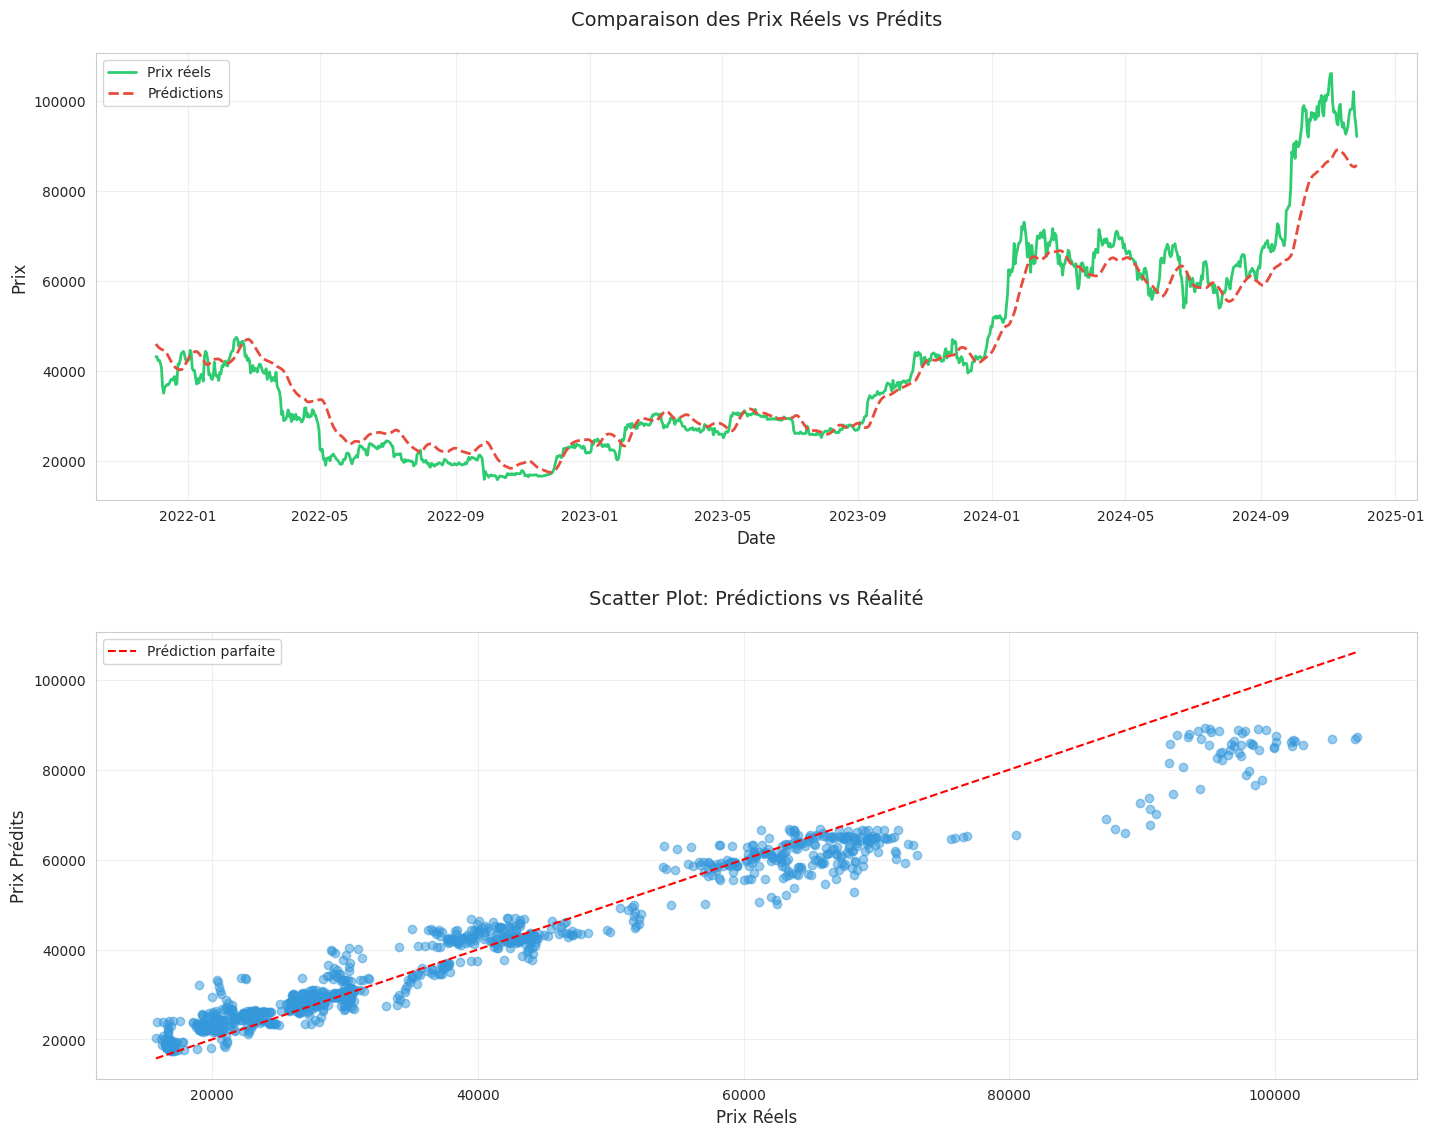

In [11]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn correctement
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_model(model, X_test, Y_test, scaler, data, X_train, config):
    print("\n" + "="*80)
    print("ÉVALUATION DU MODÈLE".center(80))
    print("="*80)

    # Paramètres initiaux
    training_size = len(X_train)
    window_size = config.data['window_size']
    features = config.data['features']
    target_column = features.index('Close')

    print("\n[1] Génération des prédictions")
    predictions = model.predict(X_test, verbose=0).reshape(-1, 1)

    # Préparation pour l'inverse transform
    pred_full = np.zeros((predictions.shape[0], len(features)))
    pred_full[:, target_column] = predictions.flatten()

    # Inverse transform
    predicted_prices = scaler.inverse_transform(pred_full)[:, target_column]
    real_prices = scaler.inverse_transform(
        np.hstack([
            np.zeros((Y_test.shape[0], target_column)),
            Y_test.reshape(-1, 1),
            np.zeros((Y_test.shape[0], len(features) - target_column - 1))
        ])
    )[:, target_column]

    print("\n[2] Calcul des métriques")
    # Métriques de base
    metrics = {
        "mae": mean_absolute_error(real_prices, predicted_prices),
        "mse": mean_squared_error(real_prices, predicted_prices),
        "rmse": np.sqrt(mean_squared_error(real_prices, predicted_prices)),
        "r2": r2_score(real_prices, predicted_prices),
        "mape": mean_absolute_percentage_error(real_prices, predicted_prices) * 100
    }

    # MASE
    naive_forecast = real_prices[:-1]
    mae_naive = mean_absolute_error(real_prices[1:], naive_forecast)
    metrics["mase"] = metrics["mae"] / mae_naive if mae_naive != 0 else None

    # Affichage des métriques
    print("\nMétriques d'évaluation:")
    for metric, value in metrics.items():
        if value is not None:
            print(f"• {metric.upper()}: {value:.4f}")

    print("\n[3] Génération des visualisations")

    # Configuration du style avec seaborn
    sns.set_style("whitegrid")

    # Création de la figure avec les subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Dates pour l'axe x
    dates = data.index[training_size + window_size:training_size + window_size + len(predicted_prices)]

    # Premier subplot : Comparaison prix réels vs prédictions
    ax1.plot(dates, real_prices, label='Prix réels', color='#2ecc71', linewidth=2)
    ax1.plot(dates, predicted_prices, label='Prédictions', color='#e74c3c', linewidth=2, linestyle='--')
    ax1.set_title('Comparaison des Prix Réels vs Prédits', fontsize=14, pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Prix', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Second subplot : Scatter plot des prédictions vs réalité
    ax2.scatter(real_prices, predicted_prices, alpha=0.5, color='#3498db')

    # Ligne parfaite de prédiction
    min_val = min(min(real_prices), min(predicted_prices))
    max_val = max(max(real_prices), max(predicted_prices))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Prédiction parfaite')

    ax2.set_title('Scatter Plot: Prédictions vs Réalité', fontsize=14, pad=20)
    ax2.set_xlabel('Prix Réels', fontsize=12)
    ax2.set_ylabel('Prix Prédits', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Ajustement de la mise en page
    plt.tight_layout(pad=3.0)

    # Log WandB optimisé
    wandb.log({
        "model_evaluation": {
            "metrics": metrics,
            "comparison_plots": wandb.Image(plt),
            "period": {
                "start": dates[0].strftime('%Y-%m-%d'),
                "end": dates[-1].strftime('%Y-%m-%d')
            }
        }
    })

    # Afficher le plot
    plt.show()
    plt.close()

    print("\n" + "="*80)
    print("RÉSUMÉ DE L'ÉVALUATION".center(80))
    print("-"*80)
    print(f"• Période d'évaluation: {dates[0].strftime('%Y-%m-%d')} au {dates[-1].strftime('%Y-%m-%d')}")
    print(f"• Nombre de prédictions: {len(predicted_prices)}")
    print(f"• Erreur moyenne absolue: {metrics['mae']:.2f}")
    print(f"• Erreur quadratique moyenne: {metrics['rmse']:.2f}")
    print(f"• Score R²: {metrics['r2']:.4f}")
    print("="*80)

    return metrics, predicted_prices, real_prices

# Appel de la fonction d'évaluation
metrics, predicted_prices, real_prices = evaluate_model(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    scaler=scaler,
    data=data,
    X_train=X_train,
    config=wandb.config
)


                             RÉSUMÉ DE L'ÉVALUATION                             
--------------------------------------------------------------------------------
• Période d'évaluation: 2021-12-03 au 2024-11-27
• Nombre de prédictions: 1091
• Erreur moyenne absolue: 3545.73
• Erreur quadratique moyenne: 5098.22
• Score R²: 0.9431

                              PRÉDICTIONS FUTURES                               

[1] Configuration de la prédiction
• Horizon de prédiction: 30 jours
• Fenêtre d'observation: 90 jours

[2] Génération des prédictions

[3] Visualisation des prédictions


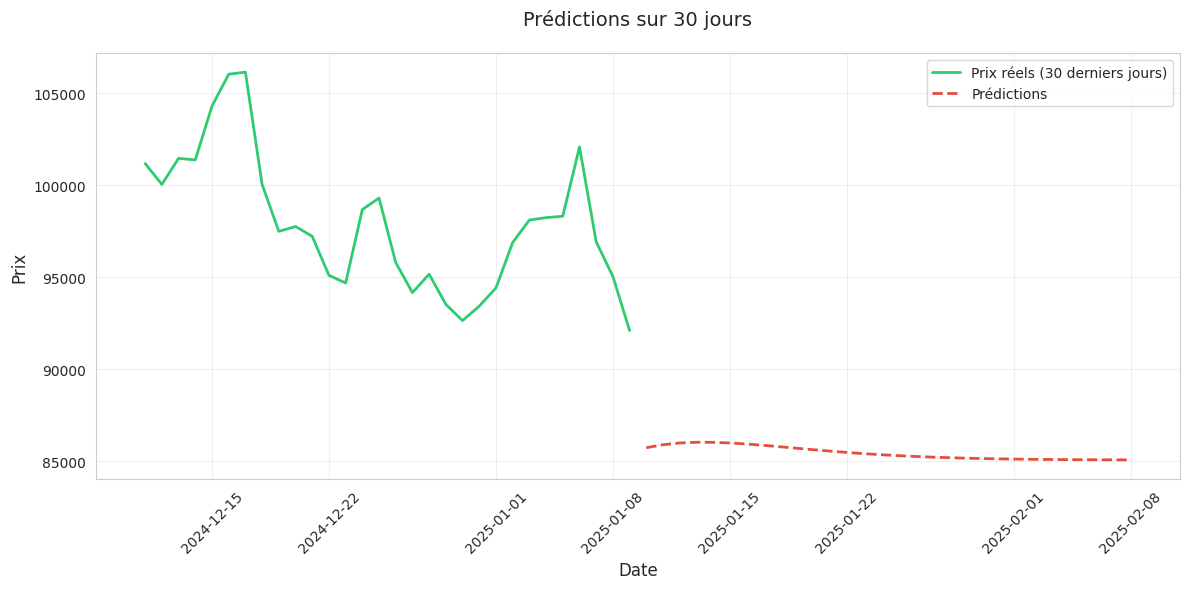


                             RÉSUMÉ DES PRÉDICTIONS                             
--------------------------------------------------------------------------------
• Période: du 2025-01-10 au 2025-02-08
• Prix initial: 85,738.39
• Prix final: 85,077.87
• Variation: -0.77%
• Volatilité: 0.06%


In [12]:
def generate_future_predictions(model, X_test, X_train, data, scaler, config):
    print("\n" + "="*80)
    print("PRÉDICTIONS FUTURES".center(80))
    print("="*80)

    # Paramètres de base
    future_days = config.data.get("future_prediction_days", 30)
    window_size = config.data['window_size']
    features = config.data['features']
    target_column_index = features.index("Close")

    print(f"\n[1] Configuration de la prédiction")
    print(f"• Horizon de prédiction: {future_days} jours")
    print(f"• Fenêtre d'observation: {window_size} jours")

    print("\n[2] Génération des prédictions")
    future_predictions = []
    last_sequence = X_test[-1]

    for _ in range(future_days):
        next_pred = model.predict(last_sequence.reshape(1, window_size, X_train.shape[2]), verbose=0)
        future_predictions.append(next_pred[0, 0])
        next_time_step = last_sequence[-1].copy()
        next_time_step[target_column_index] = next_pred[0, 0]
        last_sequence = np.append(last_sequence[1:], [next_time_step], axis=0)

    # Dénormalisation
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    pred_full = np.zeros((future_predictions.shape[0], len(features)))
    pred_full[:, target_column_index] = future_predictions.flatten()
    future_prices = scaler.inverse_transform(pred_full)[:, target_column_index]

    # Dates futures
    last_date = pd.to_datetime(data.index[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                               periods=future_days, freq='D')

    print("\n[3] Visualisation des prédictions")
    fig, ax = plt.subplots(figsize=(12, 6))

    # Ajout des 30 derniers jours réels pour contexte
    last_real_dates = data.index[-30:]
    last_real_prices = data['Close'].iloc[-30:]

    ax.plot(last_real_dates, last_real_prices,
           color='#2ecc71', label='Prix réels (30 derniers jours)',
           linewidth=2)
    ax.plot(future_dates, future_prices,
           color='#e74c3c', label='Prédictions',
           linewidth=2, linestyle='--')

    ax.set_title(f'Prédictions sur {future_days} jours', fontsize=14, pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Prix', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Calcul des statistiques clés
    variation_pct = ((future_prices[-1] - future_prices[0]) / future_prices[0]) * 100
    volatility = np.std(np.diff(future_prices) / future_prices[:-1]) * 100

    # Log WandB optimisé
    wandb.log({
        "future_forecast": {
            "plot": wandb.Image(plt),
            "metrics": {
                "price_start": float(future_prices[0]),
                "price_end": float(future_prices[-1]),
                "variation_percentage": float(variation_pct),
                "volatility_percentage": float(volatility)
            },
            "period": {
                "start": future_dates[0].strftime('%Y-%m-%d'),
                "end": future_dates[-1].strftime('%Y-%m-%d')
            }
        }
    })

    plt.show()
    plt.close()

    print("\n" + "="*80)
    print("RÉSUMÉ DES PRÉDICTIONS".center(80))
    print("-"*80)
    print(f"• Période: du {future_dates[0].strftime('%Y-%m-%d')} au {future_dates[-1].strftime('%Y-%m-%d')}")
    print(f"• Prix initial: {future_prices[0]:,.2f}")
    print(f"• Prix final: {future_prices[-1]:,.2f}")
    print(f"• Variation: {variation_pct:,.2f}%")
    print(f"• Volatilité: {volatility:,.2f}%")
    print("="*80)

    return future_dates, future_prices

# Appel de la fonction
future_dates, future_prices = generate_future_predictions(
    model=model,
    X_test=X_test,
    X_train=X_train,
    data=data,
    scaler=scaler,
    config=wandb.config
)


                     VISUALISATION COMPLÈTE DES PRÉDICTIONS                     

[1] Vérification des dimensions
• Données historiques: 1091 points
• Prédictions futures: 30 points

Dimensions des données:
• Prix réels: 1091
• Prédictions historiques: 1091
• Prédictions futures: 30
• Dates historiques: 1091


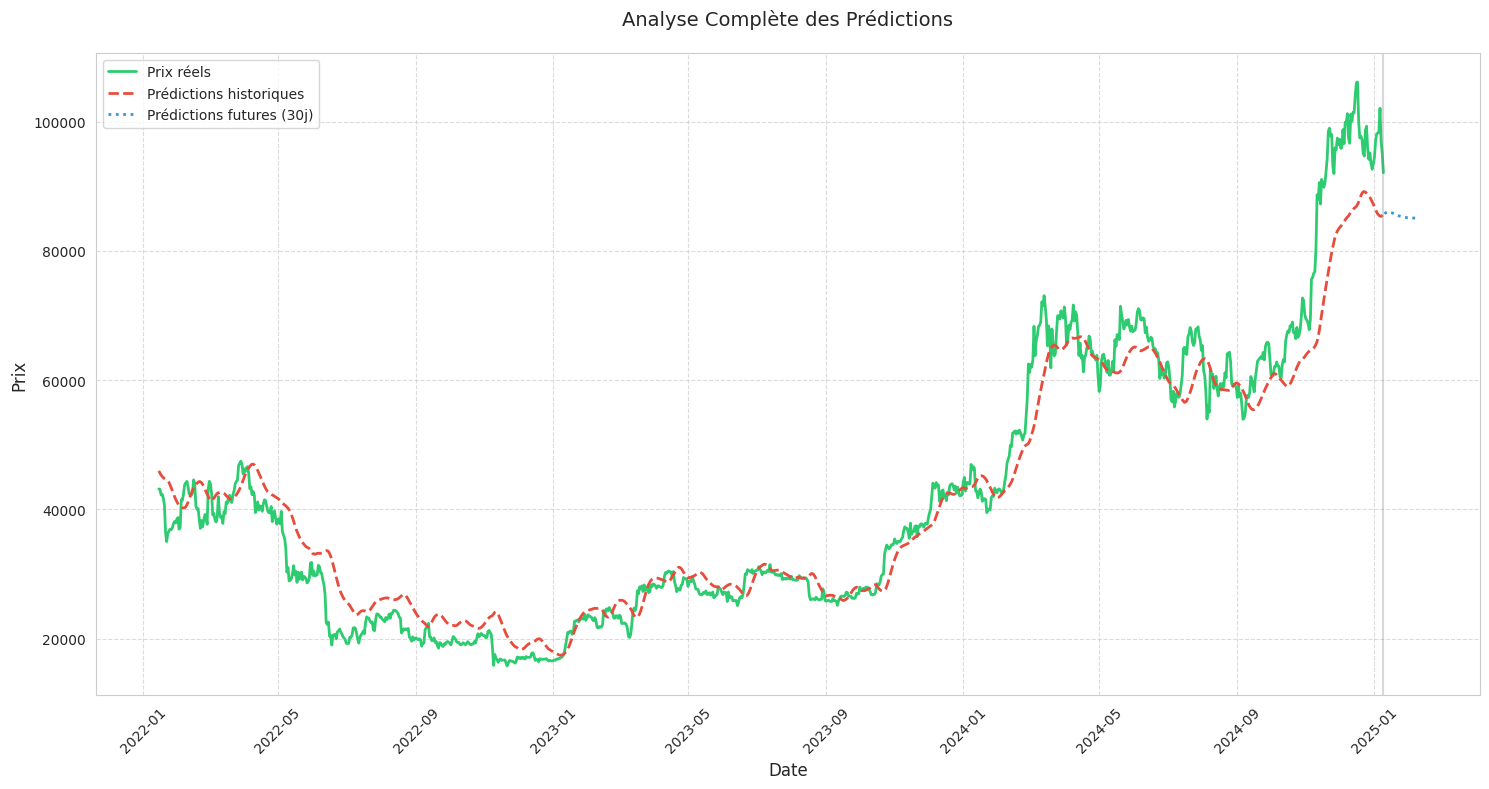

In [13]:
def visualize_combined_predictions(data, real_prices, predicted_prices, future_dates, future_prices, config):
    print("\n" + "="*80)
    print("VISUALISATION COMPLÈTE DES PRÉDICTIONS".center(80))
    print("="*80)

    # 1. Préparation des dates pour les données historiques
    training_size = int(len(data) * config.data['train_test_split'])
    window_size = config.data['window_size']

    # CORRECTION: S'assurer que nous avons le bon nombre de dates
    start_idx = len(data) - len(predicted_prices)  # On commence à partir de la fin
    historical_dates = data.index[start_idx:start_idx + len(predicted_prices)]

    print("\n[1] Vérification des dimensions")
    print(f"• Données historiques: {len(historical_dates)} points")
    print(f"• Prédictions futures: {len(future_dates)} points")
    print("\nDimensions des données:")
    print(f"• Prix réels: {len(real_prices)}")
    print(f"• Prédictions historiques: {len(predicted_prices)}")
    print(f"• Prédictions futures: {len(future_prices)}")
    print(f"• Dates historiques: {len(historical_dates)}")

    # Vérification de la cohérence des dimensions
    assert len(historical_dates) == len(real_prices) == len(predicted_prices), \
           "Les dimensions des données historiques ne correspondent pas"

    # Création de la visualisation
    plt.figure(figsize=(15, 8))

    # Prix réels et prédictions historiques
    plt.plot(historical_dates, real_prices,
             label='Prix réels',
             color='#2ecc71',
             linewidth=2)

    plt.plot(historical_dates, predicted_prices,
             label='Prédictions historiques',
             color='#e74c3c',
             linewidth=2,
             linestyle='--')

    # Prédictions futures
    plt.plot(future_dates, future_prices,
             label=f'Prédictions futures ({len(future_dates)}j)',
             color='#3498db',
             linewidth=2,
             linestyle=':')

    # Ligne de séparation
    plt.axvline(x=historical_dates[-1], color='gray', linestyle='-', alpha=0.3)

    plt.title('Analyse Complète des Prédictions', fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Prix', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Log WandB optimisé
    wandb.log({
        "complete_analysis": {
            "visualization": wandb.Image(plt),
            "metrics": {
                "last_real_price": float(real_prices[-1]),
                "first_future_price": float(future_prices[0]),
                "gap_percentage": float((future_prices[0] - real_prices[-1]) / real_prices[-1] * 100)
            }
        }
    })

    plt.show()
    plt.close()

# Appel de la fonction avec les données déjà préparées
visualization = visualize_combined_predictions(
    data=data,
    real_prices=real_prices,          # De evaluate_model
    predicted_prices=predicted_prices, # De evaluate_model
    future_dates=future_dates,        # De generate_future_predictions
    future_prices=future_prices,      # De generate_future_predictions
    config=wandb.config
)

In [14]:
# Bloc : trading_signals_and_analysis_report
# Résumé en 1 ligne : Génère un rapport d'analyse incluant les signaux de trading à court et moyen terme, les tendances, les métriques de performance, et les prédictions sur 30 jours.

def generer_rapport_analyse(real_prices, predicted_prices, future_prices, metrics, config):
    """
    Génère un rapport détaillé d'analyse des prédictions.
    """
    # Calculs de base
    prix_actuel = real_prices[-1]
    prix_predit_30j = future_prices[-1]
    variation_totale = ((prix_predit_30j - prix_actuel) / prix_actuel) * 100

    # Variations à court et moyen terme
    variations = {
        "5j": ((future_prices[4] - prix_actuel) / prix_actuel) * 100,
        "20j": ((future_prices[19] - prix_actuel) / prix_actuel) * 100
    }

    # Analyse des signaux
    signaux = {
        "5j": {
            "tendance": "HAUSSIÈRE" if variations["5j"] > 0 else "BAISSIÈRE",
            "signal": "ACHETER" if variations["5j"] > 2 else "VENDRE" if variations["5j"] < -2 else "CONSERVER"
        },
        "20j": {
            "tendance": "HAUSSIÈRE" if variations["20j"] > 0 else "BAISSIÈRE",
            "signal": "ACHETER" if variations["20j"] > 5 else "VENDRE" if variations["20j"] < -5 else "CONSERVER"
        }
    }

    # Tendances CT et MT
    tendances = {
        "ct": "HAUSSIÈRE" if variations["5j"] > 1 else "BAISSIÈRE" if variations["5j"] < -1 else "NEUTRE",
        "mt": "HAUSSIÈRE" if variations["20j"] > 2 else "BAISSIÈRE" if variations["20j"] < -2 else "NEUTRE"
    }

    # Niveau de confiance
    niveau_confiance = "ÉLEVÉE" if (metrics["r2"] > 0.9 and metrics["mape"] < 5) else \
                      "MOYENNE" if (metrics["r2"] > 0.7 and metrics["mape"] < 10) else "FAIBLE"

    # Log WandB optimisé - Uniquement les métriques essentielles pour le sweep
    wandb.log({
        "trading_analysis": {
            "prediction_accuracy": {
                "r2": metrics["r2"],
                "mape": metrics["mape"],
                "rmse": metrics["rmse"]
            },
            "prediction_signals": {
                "variation_30j": variation_totale,
                "signal_ct": signaux['5j']['signal'],
                "signal_mt": signaux['20j']['signal'],
                "confidence": niveau_confiance
            }
        }
    })

    # Génération du rapport texte
    rapport = f"""
======================================================================
RÉSULTATS DE L'ANALYSE
======================================================================

1. MÉTRIQUES DE PERFORMANCE
-----------------------------------
- RMSE: {metrics['rmse']:.2f} €
- R²: {metrics['r2']:.4f}
- MAPE: {metrics['mape']:.2f}%

2. PRÉDICTIONS
-----------------------------------
- Prix actuel: {prix_actuel:.2f} €
- Prix prédit dans 30 jours: {prix_predit_30j:.2f} €
- Variation totale prédite: {variation_totale:.2f}%

ANALYSE DE LA TENDANCE
======================================================================
Tendance à 5 jours:
Signal: TENDANCE {signaux['5j']['tendance']} - {signaux['5j']['signal']}
Niveau Confiance: {niveau_confiance}
Variation: {variations['5j']:.2f}%
Tendance Ct: {tendances['ct']}
Tendance Mt: {tendances['mt']}

Tendance à 20 jours:
Signal: TENDANCE {signaux['20j']['tendance']} - {signaux['20j']['signal']}
Niveau Confiance: {niveau_confiance}
Variation: {variations['20j']:.2f}%
Tendance Ct: {tendances['ct']}
Tendance Mt: {tendances['mt']}
"""

    return rapport, {
        "variations": variations,
        "signaux": signaux,
        "niveau_confiance": niveau_confiance,
        "tendances": tendances
    }

# Appel de la fonction
rapport, analyse_data = generer_rapport_analyse(
    real_prices=real_prices,
    predicted_prices=predicted_prices,  # Correction ici
    future_prices=future_prices,
    metrics=metrics,
    config=wandb.config
)

# Affichage du rapport
print(rapport)


RÉSULTATS DE L'ANALYSE

1. MÉTRIQUES DE PERFORMANCE
-----------------------------------
- RMSE: 5098.22 €
- R²: 0.9431
- MAPE: 9.26%

2. PRÉDICTIONS
-----------------------------------
- Prix actuel: 92103.69 €
- Prix prédit dans 30 jours: 85077.87 €
- Variation totale prédite: -7.63%

ANALYSE DE LA TENDANCE
Tendance à 5 jours:
Signal: TENDANCE BAISSIÈRE - VENDRE
Niveau Confiance: MOYENNE
Variation: -6.59%
Tendance Ct: BAISSIÈRE
Tendance Mt: BAISSIÈRE

Tendance à 20 jours:
Signal: TENDANCE BAISSIÈRE - VENDRE
Niveau Confiance: MOYENNE
Variation: -7.52%
Tendance Ct: BAISSIÈRE
Tendance Mt: BAISSIÈRE



In [15]:
# Bloc : market_analysis_and_recommendations
# Résumé en 1 ligne : Analyse les variations des prix à court et long terme, évalue les indicateurs techniques (RSI, volatilité), et génère un rapport de recommandations de trading avec des signaux visuels et niveaux de confiance, tout en loguant les résultats dans WandB.


"""
================================================================================
PHILOSOPHIE DES CONSEILS ET PARAMÈTRES
================================================================================

SIGNAUX DE TRADING :
-------------------
- FORT SIGNAL : variation > 20%
  → Indique une forte conviction dans la direction du marché
- SIGNAL : variation > 10%
  → Suggestion d'action avec conviction modérée
- MODÉRÉ : variation > 5%
  → Opportunité potentielle avec prudence
- NEUTRE : entre -5% et +5%
  → Pas de signal clair, suggère l'attente

NIVEAUX DE CONFIANCE :
---------------------
- ÉLEVÉE : variation > 10%
  → Forte probabilité de réalisation
- MOYENNE : variation > 5%
  → Probabilité moyenne de réalisation
- FAIBLE : variation ≤ 5%
  → Incertitude importante

INDICATEURS TECHNIQUES :
-----------------------
RSI (Relative Strength Index) :
- Surachat : > 70
  → Potentiel renversement à la baisse
- Survente : < 30
  → Potentiel renversement à la hausse
- Neutre : entre 30 et 70
  → Pas de signal particulier

SYMBOLES VISUELS :
-----------------
🟢 : variations positives
🔴 : variations négatives
⚪ : variations neutres
↗ : tendance haussière
↘ : tendance baissière
→ : tendance neutre
"""

import numpy as np
from datetime import datetime

import numpy as np
from datetime import datetime

def calculer_rsi(prices, period=14):
    """
    Calcule le RSI (Relative Strength Index) manuellement.
    """
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    pertes = np.where(deltas < 0, -deltas, 0)
    avg_gain = np.mean(gains[-period:])
    avg_loss = np.mean(pertes[-period:])

    if avg_loss == 0:
        return 100

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

class AnalyseMarche:
    def __init__(self, real_prices, predicted_prices, future_prices):
        self.real_prices = real_prices
        self.predicted_prices = predicted_prices
        self.future_prices = future_prices
        self.prix_actuel = real_prices[-1]
        self.variation_5j = ((future_prices[4] - self.prix_actuel) / self.prix_actuel) * 100
        self.variation_20j = ((future_prices[19] - self.prix_actuel) / self.prix_actuel) * 100
        self.rsi = calculer_rsi(real_prices)

        # Calcul de la volatilité
        returns = np.diff(real_prices[-21:]) / real_prices[-21:-1]
        self.volatilite = np.std(returns) * 100

        # Calcul des signaux et tendances
        self.signal_ct = self.determiner_signal(self.variation_5j)
        self.signal_lt = self.determiner_signal(self.variation_20j)
        self.tendance_ct = self.determiner_tendance(self.variation_5j)
        self.tendance_lt = self.determiner_tendance(self.variation_20j)
        self.etat_rsi = "Surachat" if self.rsi > 70 else "Survente" if self.rsi < 30 else "Neutre"

        # Calcul des forces des signaux
        self.force_signal_baissier = min(6, abs(min(0, self.variation_5j)) / 5 +
                                       abs(min(0, self.variation_20j)) / 10 +
                                       (1 if self.rsi < 30 else 0))
        self.force_signal_haussier = min(6, max(0, self.variation_5j) / 5 +
                                       max(0, self.variation_20j) / 10 +
                                       (1 if self.rsi > 70 else 0))

        # Détermination de la recommandation finale
        if self.force_signal_haussier > self.force_signal_baissier:
            self.recommandation = "ACHAT"
            self.couleur_recommandation = "🟢"
        elif self.force_signal_baissier > self.force_signal_haussier:
            self.recommandation = "VENTE"
            self.couleur_recommandation = "🔴"
        else:
            self.recommandation = "NEUTRE"
            self.couleur_recommandation = "⚪"

    @staticmethod
    def determiner_signal(variation):
        if variation > 20:
            return "FORT SIGNAL D'ACHAT"
        elif variation > 10:
            return "SIGNAL D'ACHAT"
        elif variation > 5:
            return "ACHAT MODÉRÉ"
        elif variation < -20:
            return "FORT SIGNAL DE VENTE"
        elif variation < -10:
            return "SIGNAL DE VENTE"
        elif variation < -5:
            return "VENTE MODÉRÉE"
        else:
            return "NEUTRE"

    @staticmethod
    def determiner_tendance(variation):
        if variation > 0:
            return "HAUSSIÈRE"
        elif variation < 0:
            return "BAISSIÈRE"
        else:
            return "NEUTRE"

    def generer_barre_force(self, force):
        return "=" * int(force * 10) + " " * (60 - int(force * 10)) + f" ({force:.1f}/6)"

    def formater_variation(self, var):
        return f"🟢 {var:.2f}%" if var > 0 else f"🔴 {var:.2f}%" if var < 0 else f"⚪ {var:.2f}%"

    def generer_rapport(self):
        rapport = f"""
================================================================================
ANALYSE DE MARCHÉ - {datetime.now().strftime('%d/%m/%Y')}
================================================================================

📊 TENDANCE COURT TERME (5 JOURS)
Signal      : {self.signal_ct}
Confiance   : {"ÉLEVÉE" if abs(self.variation_5j) > 10 else "MOYENNE" if abs(self.variation_5j) > 5 else "FAIBLE"}
Variation   : {self.formater_variation(self.variation_5j)}
Tendance    : {self.tendance_ct}

📈 TENDANCE LONG TERME (20 JOURS)
Signal      : {self.signal_lt}
Confiance   : {"ÉLEVÉE" if abs(self.variation_20j) > 20 else "MOYENNE" if abs(self.variation_20j) > 10 else "FAIBLE"}
Variation   : {self.formater_variation(self.variation_20j)}
Tendance    : {self.tendance_lt}

🔧 INDICATEURS TECHNIQUES
RSI (14 jours) : {self.rsi:.2f}
               {self.etat_rsi}
Volatilité    : {self.volatilite:.2f}%

================================================================================
RECOMMANDATION FINALE
================================================================================

{self.couleur_recommandation} RECOMMANDATION : {self.recommandation}

📊 Force des signaux :
Signal baissier : {self.generer_barre_force(self.force_signal_baissier)}
Signal haussier : {self.generer_barre_force(self.force_signal_haussier)}

📋 RÉSUMÉ DES POINTS CLÉS
• Tendance principale : {"↗" if self.tendance_lt == "HAUSSIÈRE" else "↘" if self.tendance_lt == "BAISSIÈRE" else "→"} {self.tendance_lt}
• Variation anticipée (5j)  : {self.formater_variation(self.variation_5j)}
• Variation anticipée (20j) : {self.formater_variation(self.variation_20j)}
• État du RSI : {self.etat_rsi}
"""
        return rapport, {
            "signal_ct": self.signal_ct,
            "signal_lt": self.signal_lt,
            "rsi": self.rsi,
            "volatilite": self.volatilite,
            "recommandation": self.recommandation
        }

# Utilisation
def analyser_marche(real_prices, predicted_prices, future_prices):
    analyse = AnalyseMarche(real_prices, predicted_prices, future_prices)
    rapport, metriques = analyse.generer_rapport()

    # Affichage du rapport
    print(rapport)

    # Enregistrement optimisé dans W&B - uniquement les métriques essentielles
    wandb.log({
        "market_analysis": {
            "indicators": {
                "rsi": analyse.rsi,
                "volatility": analyse.volatilite
            },
            "predictions": {
                "variation_5d": analyse.variation_5j,
                "variation_20d": analyse.variation_20j,
                "recommendation": analyse.recommandation
            }
        }
    })

    return rapport, metriques

# Utilisation de la nouvelle fonction
rapport, metriques = analyser_marche(real_prices, predicted_prices, future_prices)


ANALYSE DE MARCHÉ - 09/01/2025

📊 TENDANCE COURT TERME (5 JOURS)
Signal      : VENTE MODÉRÉE
Confiance   : MOYENNE
Variation   : 🔴 -6.59%
Tendance    : BAISSIÈRE

📈 TENDANCE LONG TERME (20 JOURS)
Signal      : VENTE MODÉRÉE
Confiance   : FAIBLE
Variation   : 🔴 -7.52%
Tendance    : BAISSIÈRE

🔧 INDICATEURS TECHNIQUES
RSI (14 jours) : 42.48
               Neutre
Volatilité    : 2.30%

RECOMMANDATION FINALE

🔴 RECOMMANDATION : VENTE

📊 Force des signaux :
Signal baissier : ====================                                         (2.1/6)
Signal haussier :                                                              (0.0/6)

📋 RÉSUMÉ DES POINTS CLÉS
• Tendance principale : ↘ BAISSIÈRE
• Variation anticipée (5j)  : 🔴 -6.59%
• Variation anticipée (20j) : 🔴 -7.52%
• État du RSI : Neutre



In [16]:
#Cloture de la session WandB
wandb.finish()

In [17]:
!pip freeze > requirements.txt